# Tech Task description

This file is attached in 2 formats:
- jupyter notebook (`.ipynb`), where you're suggested to put your solution
- `.html` version just to look at while you're solving these tasks elsewhere

*Disclaimer*
<br>All the tasks are expected to be done in Python 3.6+, 
<br>using any libraries you need, preferably `NumPy`, `pandas`, `scipy`, `statsmodels`
<br>(if you use DL libraries $\implies$ nice to use `tensorflow 2.x` with keras interface)



<img src="http://www.musicmonks.com/wp-content/uploads/2012/05/maythe4thbewithyou.png" width="250" align="left">

## Task 1
Consider small textual dataset `articles.csv`. 
It consists of 2 columns:

- **text**: some sentence (aka "word cloud" split by spaces), extracted from specific article
- **category**: hashed category for that article

Given this data, please write (preferred - using `pandas` library functionality) code, <br>that extracts top-5 words with their correspondent counts from `text` column of all texts within `category` №3

**Example output**: list of tuples or pandas.Series with index == word and values == counts

<code>[
    ('most_popular_w1', 200), 
    ('most_popular_w2', 190), 
    ('most_popular_w3', 180), 
    ('most_popular_w4', 151), 
    ('most_popular_w5', 100),
]
</code>

In [79]:
import pandas as pd
import numpy as np
from collections import Counter
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('articles.csv')
df = df.loc[df.category == 3]
results = Counter()
df['text'].str.lower().str.split().apply(results.update)
results.most_common()[:5]

[('you', 149), ('did', 142), ('this', 113), ('task', 79), ('correctly', 46)]

<img src="https://i.pinimg.com/236x/22/cd/e8/22cde821e9dc3f2db322acd43f058282.jpg" width="250" align="left">

## Task 2
Consider $X \sim U[0,1]$, $Y \sim U[0,1]$ are two independent random variables, uniformly distributed on [0,1].
<br>Let $Z = 2X - Y$
<br>Find the probability $P(Z \leq 1)$

P.s. If you can't quickly figure out analytical solution <img src="https://images-na.ssl-images-amazon.com/images/I/51HGZoQ64IL._UX395_.jpg" width="40" align="left">
then propose alternative method to solve this task (say, numerically)

Potential analytical solution:
$\frac{1}{2} \cdot 2=1$

## Task 3
Consider we have 2 similar groups of shops with similar dynamics:
<br>(these groups are located in different regions)
- group A = $a_{1}, a_{2}, ..., a_{n}$ 
<br>(control group, no actions were taken to impact repricing procedure)
- group B = $b_{1}, b_{2}, ..., b_{m}$ 
<br>(test group, we applied secret machine learning methods here to recommend new prices and boost performance)
<br> $m \neq n$ in general case 

<br>Then, based on relevant base period $t_{0}$ (to exclude trend impact and market natural growth tendencies), 
<br>we measured year-over-year growth of client's KPI in pilot period $t_{1}$ for every abovementioned shop: <br>$g_{x} = \frac{KPI(x(t_{1}))}{KPI(x(t_{0}))} - 1 \:\: \forall x \in A \cup B$

Given these growth rates $g_{a_{1}}, ... , g_{a_{n}}$ and $g_{b_{1}}, ... , g_{b_{m}}$ in file `pilot_stats.json`
<br>argue and propose a way to estimate whether we had **significant positive impact** on client's KPI,
<br>**in test group B** (caused by our actions) over "do-nothing scenario" in group A.
<br>Consider significance level 95%. 
<br>**if needed**, perform some visualization and calculate confidence interval for estimated parameter 

<br>**Example output**:
<code>{
    'significant_impact': True/False, 
    'pvalue': p-value,
    ['confidence_interval': (ci_LB, ci_UB)]
}</code>

This task is also expected to be done in Python.

<img src="https://miro.medium.com/max/273/1*oTxZV0CGbMaHu_RWspnLbg.jpeg" align="left" width="100"/>

In [31]:
with open('pilot_stats.json', 'r') as f:
    data = json.load(f)
    
print('N group_a (control): {}'.format(len(data['group_a'])))
print('N group_b (treatment): {}'.format(len(data['group_b'])))    

N group_a (control): 120
N group_b (treatment): 80


In [5]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    
    return x, y

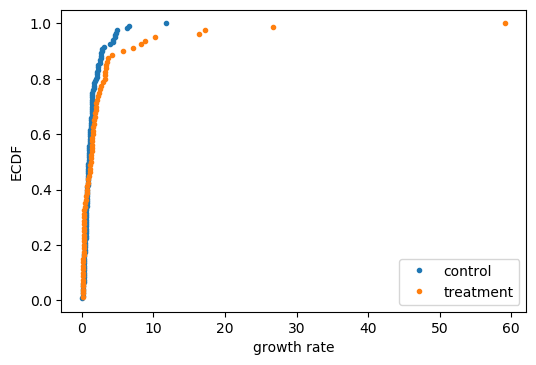

In [6]:
x_a, y_a = ecdf(data['group_a'])
x_b, y_b = ecdf(data['group_b'])

plt.figure(dpi=100)
plt.plot(x_a,y_a, linestyle='none',
marker='.', label='control')
plt.plot(x_b,y_b, linestyle='none',
marker='.', label='treatment')
plt.xlabel('growth rate')
plt.ylabel('ECDF')
plt.legend()
plt.show()

# Proposed test
After examining the data I propose to conduct a bootstrap means difference test.\
Null hypothesis - means of two groups are equal:\
$H_{0}: \mu_{1}=\mu_{2}$\
Alternative hypothesis - control group's mean is lesser than control group's mean:\
$H_{1}: \mu_{1}<\mu_{2}$

In [11]:
def draw_bs_reps(data, func, N):   
    sample = np.empty(N)
    for i in range(N):
        bs_sample = np.random.choice(data, len(data))
        sample[i] = func(bs_sample)
    return sample


def bs_mean_difference_test(data_A, data_B):
    np.random.seed(0)
    
    #### test ####
    mean_diff = np.mean(group_B) - np.mean(group_A)

    combined_mean = np.mean(np.concatenate((data_A, data_B)))
    A_shifted = data_A-np.mean(data_A)+combined_mean
    B_shifted = data_B-np.mean(data_B)+combined_mean
    
    A_replicates = draw_bs_reps(A_shifted, np.mean, 100000)
    B_replicates = draw_bs_reps(B_shifted, np.mean, 100000)
    
    bs_diff_replicates = B_replicates - A_replicates
    
    p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)
    hyp_test = p<=0.05

    #### confidence interval ####
    bs_group_A_mean = draw_bs_reps(data_A, np.mean, 100000)
    bs_group_B_mean = draw_bs_reps(data_B, np.mean, 100000)
    replicate_mean_diff = bs_group_B_mean - bs_group_A_mean
    conf_int = np.percentile(replicate_mean_diff,[2.5, 97.5])
    
    #### results ####
    result = {}
    result['significant_impact'] = hyp_test
    result['pvalue'] = p
    result['confidence_interval'] = conf_int
    
    return result

In [14]:
group_A = np.array(data['group_a'])
group_B = np.array(data['group_b'])

results = bs_mean_difference_test(group_A, group_B)
print(results)

{'significant_impact': True, 'pvalue': 0.03931, 'confidence_interval': array([0.28062635, 3.58561933])}


## Task 4

You're given small dataset `task4_data.csv` (encoding=`utf-8`, comma-delimited), it consists of:
- `x1`, `x2`, `x3`: numerical features
- `id`: row id, simple autoincremented id, do not use this feature in production :)
- `cat1`, `cat2`: categorical features
- `target`: regression target you need to predict for test set
- `is_test`: whether it's test data (True) or train data (False)

Your task is to select ML model (`y_train.mean()` is not enough) of your choice 
<br>(preferable - neural network in `Keras/tensorflow`)
<br>train it on correspondent dataset and make prediction for `target` value where `is_test` == True
<br>Exploratory analysis, as well as validation strategy, loss and metric choices are up to you
<br>Pay more attention to methodology than to model complexity

**Desired output** - `test.csv` file with (`id`, `target`) pairs

## train/test split

In [17]:
df = pd.read_csv('task4_data.csv')
df = df[['id', 'x1', 'x2', 'x3', 'cat1', 'cat2', 'is_test', 'target']]

train = df.loc[df.is_test == False]
test = df.loc[df.is_test == True]

X_train = train.iloc[:,1:-2]
y_train = train[['target']]
X_test = test.iloc[:,1:-2]

In [78]:
df.iloc[:,:-1].isna().sum()

id         0
x1         0
x2         0
x3         0
cat1       0
cat2       0
is_test    0
dtype: int64

In [61]:
df.iloc[:,1:4].corr()

,x1,x2,x3
x1,1.000000,-0.002766,-0.015583
x2,-0.002766,1.000000,-0.042289
x3,-0.015583,-0.042289,1.000000


In [73]:
print('cat1')
print(df.cat1.value_counts(normalize=True, sort=True))
print('cat2')
print(df.cat2.value_counts(normalize=True, sort=True))

cat1
b    0.285714
d    0.285714
a    0.250000
c    0.178571
Name: cat1, dtype: float64
cat2
a    0.254643
b    0.250000
d    0.250000
c    0.245357
Name: cat2, dtype: float64


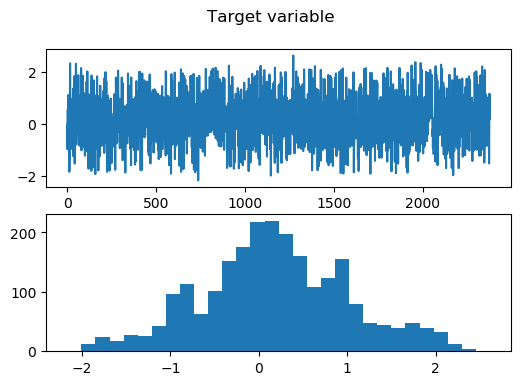

In [102]:
fig, axs = plt.subplots(2, dpi=100)
fig.suptitle('Target variable')
axs[0].plot(y_train['target'])
axs[1].hist(y_train['target'],bins=30)
plt.show()

## pre-processing

In [18]:
# OneHotEncoding is used for categorical data.
ohe = OneHotEncoder(drop='first').fit(X_train.iloc[:,3:])
categorical = pd.DataFrame(ohe.transform(X_train.iloc[:,3:]).toarray())
categorical.columns = ohe.get_feature_names()

# Standard Scaler is used for numerical data.
scaler = StandardScaler()
numerical = scaler.fit_transform(X_train.iloc[:,0:3])
numerical = pd.DataFrame(numerical)
numerical.columns = X_train.iloc[:,0:3].columns
X_train = pd.concat([numerical, categorical], axis=1)

# Same pre-processing is applied on X_test.
categorical_test = pd.DataFrame(ohe.transform(X_test.iloc[:,3:]).toarray())
categorical_test.columns = ohe.get_feature_names()
numerical_test = pd.DataFrame(scaler.transform(X_test.iloc[:,0:3]))
numerical_test.columns = X_train.iloc[:,0:3].columns
X_test = pd.concat([numerical_test, categorical_test], axis=1)

## modeling

In [80]:
np.random.seed(1) 
EPOCHS = 100
BATCH_SIZE = 32

""" 
Dense network is usually the first thing to try. 
Depending on nature of the data there may be better architectures.
"""
model = Sequential()
model.add(Dense(64, input_dim = X_train.values.shape[1], activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Cross-validation is used as a validation strategy.
monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, 
patience=5, verbose=1, mode='auto', restore_best_weights=True)

model.fit(X_train.values,y_train.values,validation_split=0.1, 
          callbacks=[monitor], verbose=2, epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 2142 samples, validate on 238 samples
Epoch 1/100
 - 2s - loss: 0.5949 - val_loss: 0.4586
Epoch 2/100
 - 0s - loss: 0.4419 - val_loss: 0.3227
Epoch 3/100
 - 0s - loss: 0.3608 - val_loss: 0.2559
Epoch 4/100
 - 0s - loss: 0.3022 - val_loss: 0.2263
Epoch 5/100
 - 0s - loss: 0.2860 - val_loss: 0.2156
Epoch 6/100
 - 0s - loss: 0.2706 - val_loss: 0.1984
Epoch 7/100
 - 0s - loss: 0.2414 - val_loss: 0.1872
Epoch 8/100
 - 0s - loss: 0.2421 - val_loss: 0.1684
Epoch 9/100
 - 0s - loss: 0.2233 - val_loss: 0.1537
Epoch 10/100
 - 0s - loss: 0.2039 - val_loss: 0.1343
Epoch 11/100
 - 0s - loss: 0.1967 - val_loss: 0.1272
Epoch 12/100
 - 0s - loss: 0.2023 - val_loss: 0.1186
Epoch 13/100
 - 0s - loss: 0.1779 - val_loss: 0.0990
Epoch 14/100
 - 0s - loss: 0.1662 - val_loss: 0.0999
Epoch 15/100
 - 0s - loss: 0.1519 - val_loss: 0.0867
Epoch 16/100
 - 0s - loss: 0.1465 - val_loss: 0.0889
Epoch 17/100
 - 0s - loss: 0.1377 - val_loss: 0.0791
Epoch 18/100
 - 0s - loss: 0.1383 - val_loss: 0.0752
Epoch 19

In [99]:
ids = df.loc[df.is_test==True]['id']
predictions = model.predict(X_test).reshape(420)
test = pd.DataFrame({'id':ids, 'target':predictions})
#test.reset_index(inplace=True, drop=True)
test.to_csv('test.csv', index=False)

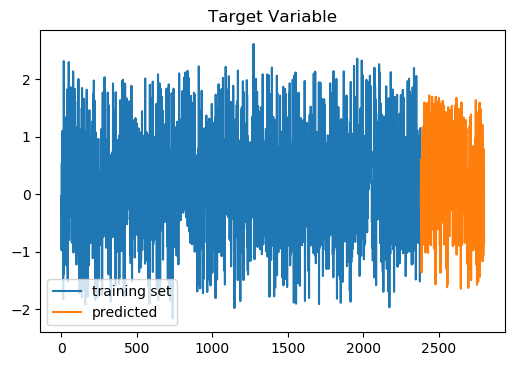

In [100]:
plt.figure(dpi=100)
plt.plot(y_train['target'], label='training set')
plt.plot(test['target'], label='predicted')
plt.legend(loc='lower left')
plt.title('Target Variable')
plt.show()